In [32]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Math

from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [19]:
np.random.seed(0)

In [20]:
# the code is [[4, 2, 2]]
# we encode 2 logical qubits into 4 physical qubits

Hx = np.array([
    [1, 1, 1, 1]
], dtype=int)

Hz = np.array([
    [1, 1, 1, 1]
], dtype=int)

Lx = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
Lz = np.array([[1, 0, 0, 1], [0, 1, 1, 0]])

print(f"We have {Hx.shape[1]} data qubits")
print(f"We have {Hx.shape[0]} X-Stabilizers")
print(f"We have {Hz.shape[0]} Z-Stabilizers")
print(f"We have {Hx.shape[1] + Hx.shape[0] + Hz.shape[0]} physical qubits")
print(f"We have {Lx.shape[0]} logical qubits")


We have 4 data qubits
We have 1 X-Stabilizers
We have 1 Z-Stabilizers
We have 6 physical qubits
We have 2 logical qubits


In [21]:
orthogonality = (Hx @ Hz.T) % 2
display(Math(r'\text{Orthogonality test: } H_X \cdot H_Z^T \text{ mod 2 gave}'))

<IPython.core.display.Math object>

In [25]:
anticommutation = (Lx @ Lz.T) - (Lz @ Lx.T)
print(anticommutation)

[[0 0]
 [0 0]]


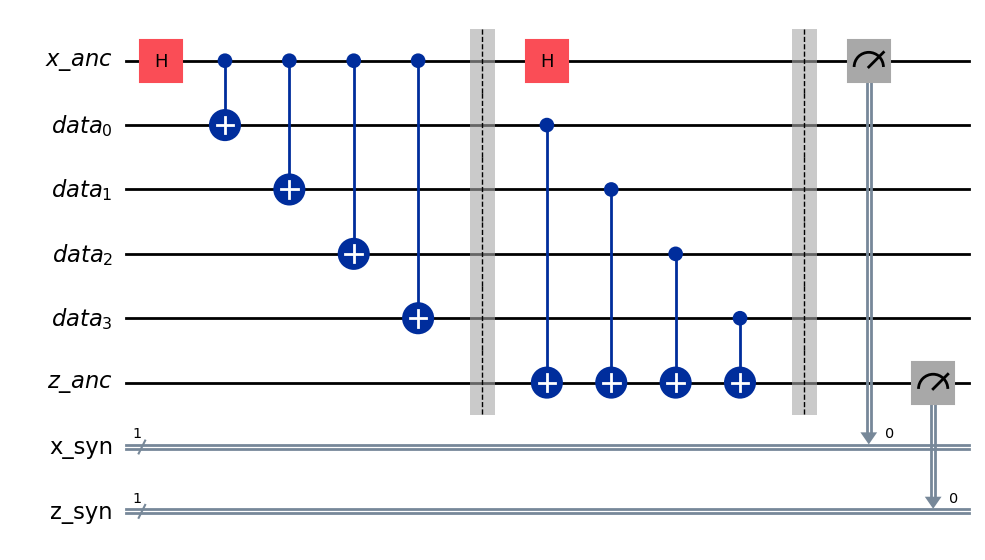

In [30]:
data = QuantumRegister(4, 'data')
x_ancillas = QuantumRegister(1, 'x_anc')
z_ancillas = QuantumRegister(1, 'z_anc')

x_meas = ClassicalRegister(1, 'x_syn')
z_meas = ClassicalRegister(1, 'z_syn')

qc = QuantumCircuit(x_ancillas, data, z_ancillas, x_meas, z_meas)

qc.h(x_ancillas)

qc.cx(x_ancillas, data[0])
qc.cx(x_ancillas, data[1])
qc.cx(x_ancillas, data[2])
qc.cx(x_ancillas, data[3])

qc.barrier()

qc.cx(data[0], z_ancillas)
qc.cx(data[1], z_ancillas)
qc.cx(data[2], z_ancillas)
qc.cx(data[3], z_ancillas)

qc.h(x_ancillas)

qc.barrier()

qc.measure(x_ancillas, x_meas)
qc.measure(z_ancillas,z_meas)

circuit_drawer(qc, output="mpl")

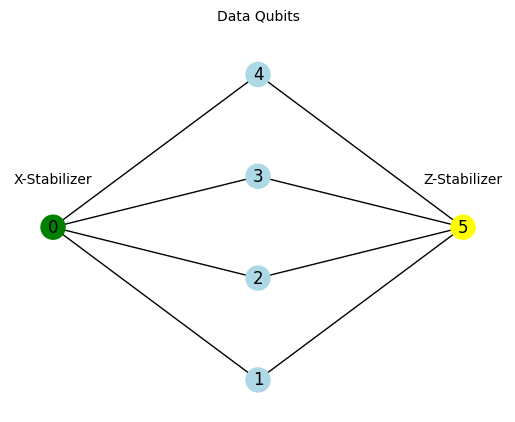

In [48]:
G = nx.Graph()

G.add_edge(0, 1)
G.add_edge(0, 2)
G.add_edge(0, 3)
G.add_edge(0, 4)

G.add_edge(1, 5)
G.add_edge(2, 5)
G.add_edge(3, 5)
G.add_edge(4, 5)

pos = {
    0: (0, 0), 
    1: (1, -1.5), 
    2: (1, -0.5), 
    3: (1, 0.5), 
    4: (1, 1.5), 
    5: (2, 0), 
}

node_colors = ['green' if node in [0] else 'yellow' if node in [5] else 'lightblue' for node in G.nodes()]
nx.draw_networkx(G, pos, node_color=node_colors, edge_color=None)

plt.text(0, 0.4, 'X-Stabilizer', ha='center', va='bottom', fontsize=10)
plt.text(2, 0.4, 'Z-Stabilizer', ha='center', va='bottom', fontsize=10)
plt.text(1, 2, 'Data Qubits', ha='center', va='bottom', fontsize=10)

ax = plt.gca()
plt.axis("off")
plt.show()